# Personal Finance Machine Learning

The goal of this notebook is to create machine learning models to tackle 2 problems:

1) Supervised learning: Create a classification model that can predict the topic of a given submission title.

2) Unsupervised learning: Create a topic modeling system that can generate topics based on the words in the submission title.

## 2) Topic Modeling

As the phrase suggests, topic modeling is using collection of texts to find hidden patterns and re-structuring those words such that we can "create" topics. The way it works is very similar to the concept of clustering in unsupervised learning problems. Without using any of the given topics from the dataset, we will use machine learning algorithms to discover groups of similar words/examples within each text post, resulting in different clusters. The issue with the current topics in place is that some may not be that relevant while others may be too similar to one another (like a multi-collinearity), resulting in repetitive topics. Of course, there are no guarantees that the generated topics will be any better than the topics currently used by /r/personalfinance but it will certainly be interesting to observe the trends that show up. 

We will be implementing 2 types of Latent Dirichlet Allocation models: the first will be the LDA model from gensim and the second will be the one from sci-kit learn's library. Both have their own advantages: gensim is more intuitive whereas sci-kit learn allows us to use the fit-transform method and use grid-search CV. 

The way the topic-modeling process for each model will be structured is as follows:

- 1) Import the relevant libraries and packages.

- 2) Create the necessary features.

- 3) Create the hyper-parameter tuning pipeline.

- 4) Build the Latent Dirichlet Allocation model.

- 5) Evaluate the model.

### 2a) Topic Modeling with gensim

**1) Import relevant libraries and packages**

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

# Import the data
from pf import *

C:\Users\Joshua\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Sci-kit learn packages
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

**2) Feature Engineering**

Before we begin creating the pipeline and models, we will need to first create the features that we will be inputting into the LDA model. We do this by using a bag-of-words model which assigns each token an id number and also counts the frequency of a token in each text (document).

In [3]:
# We will be using the lemmatized_text feature as the input data
dataset = df.lemmatized_text

# Phrases need to show up a minimum of 5 times and threshold for the score is set at 100.
bigram = gensim.models.phrases.Phrases(dataset, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [4]:
# Print bigrams of the first text
print(bigram_mod[dataset[0]])

['way', 'make', 'extra', 'side', 'money']


In [5]:
# Function that returns a list of bigrams for each text.
def create_bigrams(text):
    return [bigram_mod[doc] for doc in text]

# Create the bigrams for the dataset
data_bigrams = create_bigrams(dataset)

# Create Dictionary
dictionary = corpora.Dictionary(data_bigrams)

In [6]:
# Filter out tokens that appear less than 5 times and/or appear in more than 50% of documents. This will get rid of outliers and un-important words.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [7]:
# Let's take a peek at the dictionary
count = 0
for x in dictionary.token2id.items():
    count +=1
    print(x)
    if count == 10:
        break

('extra', 0)
('make', 1)
('money', 2)
('side', 3)
('way', 4)
('blind', 5)
('go', 6)
('help', 7)
('homeless', 8)
('job', 9)


In [8]:
# Check the number of texts that were processed. It should be 10177 (since that's the number of rows).
print('Number of Documents: {}'.format(dictionary.num_docs))
# Check the number of unique tokens by calling the dictionary object
print(dictionary)

Number of Documents: 10177
Dictionary(4709 unique tokens: ['extra', 'make', 'money', 'side', 'way']...)


In [9]:
# Create a bag of words
corpus = [dictionary.doc2bow(text) for text in data_bigrams]

# View sample text and its respective bag of words transformation
print(data_bigrams[0])
print(corpus[0])

['way', 'make', 'extra', 'side', 'money']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


While using a bag-of-words model does the job in counting the frequency of each word per document, we want to better quantify the signature words which don't appear as frequently as common words. For this reason, we will also introduce a **term frequency - inverse document frequency (tf-idf) model**. 

In [10]:
# Import the models module
from gensim import models

# Fit the bag of words into the tf-idf model
tfidf = models.TfidfModel(corpus)
# Create a new corpus using the tf-idf model
corpus_tfidf = tfidf[corpus]

In [30]:
# Take a look at the first document using the bag-of-words vectorization vs tf-idf vectorization
print(data_bigrams[0])
print(corpus[0])
print(corpus_tfidf[0])

['way', 'make', 'extra', 'side', 'money']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
[(0, 0.5392389089986213), (1, 0.228596437753383), (2, 0.23277485092437628), (3, 0.6866754165273157), (4, 0.3622951956383253)]


**3) Create the hyper-parameter tuning pipeline using Gensim.**

While there are many different parameters used in creating gensim's LDA model, the 2 most important ones in the gensim LDA model are:

1) **number of topics (num_topics)** - The number of topics that are created from the bag-of-words

2) **alpha value (alpha)** - The alpha value controls the mixture of topics for any given document. The greater the alpha, the greater the variety of topics will appear for any given document. The lower the alpha, the lower the variety of topics.

According to Griffiths and Steyvers (2004), it is suggested to use a value of 50/k (where k is number of topics) for α. However, gensim allows us to specify 'auto' for the alpha parameter, which causes the machine to automatically estimate alpha based off of the corpus we train with. This conveniently means that we won't have to test out different alpha values.

To determine which are the best hyper-parameters, we will be evaluating each iteration of the model based on its performance on its **coherence value**. Coherence is the measure of how much a document makes sense given the context of the words in relation to each other.

In [38]:
def LDA_pipeline(dictionary, corpus, texts, start, limit ,step):
    model_list = []
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

**4) Build the Latent Dirichlet Allocation model.**

Next let's build the LDA model by fitting the dictionary and corpus.

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model_list, coherence_values = LDA_pipeline(dictionary=dictionary, corpus=corpus, texts=data_bigrams, start=2, limit=40, step=6)

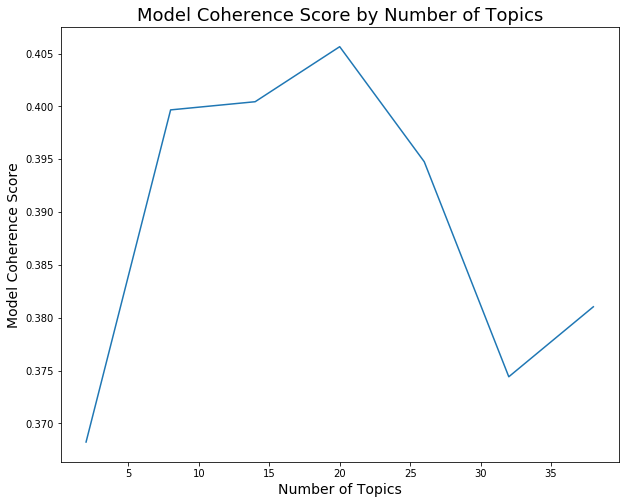

In [64]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10,8))
plt.plot(x, coherence_values)
plt.title('Model Coherence Score by Number of Topics', fontsize = 18)
plt.xlabel("Number of Topics", fontsize = 14)
plt.ylabel("Model Coherence Score", fontsize = 14)
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, ", Coherence Value: ", round(cv, 4))

Number of Topics = 2 , Coherence Value:  0.3682
Number of Topics = 8 , Coherence Value:  0.3997
Number of Topics = 14 , Coherence Value:  0.4004
Number of Topics = 20 , Coherence Value:  0.4056
Number of Topics = 26 , Coherence Value:  0.3948
Number of Topics = 32 , Coherence Value:  0.3744
Number of Topics = 38 , Coherence Value:  0.381


As we can see, the coherence value peaks when the number of topics is equal to 20. Let's select this model from the model list and print the topics.

In [84]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.048*"pay" + 0.040*"loan" + 0.030*"debt" + 0.018*"car" + 0.017*"month" + '
  '0.014*"student" + 0.013*"year" + 0.013*"home" + 0.012*"payment" + '
  '0.011*"take"'),
 (1,
  '0.024*"not" + 0.022*"get" + 0.013*"be" + 0.013*"do" + 0.013*"pay" + '
  '0.012*"work" + 0.012*"year" + 0.012*"month" + 0.011*"time" + 0.010*"have"'),
 (2,
  '0.024*"not" + 0.016*"would" + 0.016*"transfer" + 0.014*"account" + '
  '0.013*"do" + 0.013*"get" + 0.012*"bank" + 0.012*"be" + 0.009*"money" + '
  '0.009*"have"'),
 (3,
  '0.037*"loan" + 0.024*"year" + 0.023*"pay" + 0.022*"student" + '
  '0.016*"school" + 0.014*"interest" + 0.012*"would" + 0.012*"work" + '
  '0.012*"take" + 0.011*"college"'),
 (4,
  '0.026*"tsp" + 0.020*"month" + 0.019*"work" + 0.017*"hour" + 0.016*"pay" + '
  '0.014*"make" + 0.014*"would" + 0.013*"job" + 0.013*"get" + 0.012*"need"'),
 (5,
  '0.024*"get" + 0.013*"credit" + 0.012*"not" + 0.011*"card" + 0.010*"would" + '
  '0.008*"do" + 0.008*"have" + 0.008*"balance" + 0.008*"pay" + 0.00

The model has generated some topics which are clearly defined such as topic 3 (loans), topic 6 (home mortgage), and topic 8 (credit cards). However other topics are more ambiguous and don't do a good job of being specific such as topic 0, topic 1, and topic 4. Besides using the coherence value, we can also use **perplexity** to measure the effectiveness of this model.

Perplexity (in the context of Natural Language Processing) describes how well the model can predict the next word. An example is if you had wanted to predict a number from 1 to 6 and you decide to use a die. In this case, the die's perplexity with this particular problem would be 6 because you would be correct in guessing the right number 1/6th of the time. In our case, the perplexity would be measuring how well the model can predict the topic based on a given text and how well it can predict a word based on a given topic. 

The closer the perplexity is to 1, the better the model is at predicting unseen data. 

In [43]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.927242648534981

Coherence Score:  0.405645940776619


With a perplexity absolute value of 6.9, it would be analogous to correctly predicting a number using a 7-sided die. 

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

C:\Users\Joshua\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.024289 -0.043442       1        1  11.585420
8      0.072054 -0.061714       2        1   8.863679
10     0.161688  0.007853       3        1   8.602626
3     -0.021583 -0.054469       4        1   7.030904
19    -0.003812 -0.038993       5        1   6.463037
12     0.002274  0.037832       6        1   6.399113
15    -0.047038  0.022428       7        1   5.847406
13    -0.072278  0.027795       8        1   5.653610
6     -0.083341 -0.059683       9        1   5.435427
17    -0.019797 -0.061662      10        1   4.765400
14     0.080758  0.056104      11        1   4.691297
16    -0.060169  0.071958      12        1   4.626045
0     -0.062515 -0.128471      13        1   4.490130
9      0.076863  0.030785      14        1   3.612847
2      0.080905  0.071326      15        1   2.778799
11    -0.111366  0.198463      16        1   2.229377
5      0.024546 -0.025787      17        1   1.988460
7     -0.138383 -0.033501      18        1   1.847190
18     0.106645  0.010799      19        1   1.552460
4     -0.009741 -0.027622      20        1   1.536783, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
116   Default  5849.000000      credit  5849.000000  30.0000  30.0000
369   Default  2238.000000        fund  2238.000000  29.0000  29.0000
168   Default  5335.000000        loan  5335.000000  28.0000  28.0000
113   Default  3564.000000        card  3564.000000  27.0000  27.0000
455   Default  2380.000000         tax  2380.000000  26.0000  26.0000
19    Default  3332.000000         car  3332.000000  25.0000  25.0000
51    Default  3865.000000     account  3865.000000  24.0000  24.0000
219   Default  2157.000000       house  2157.000000  23.0000  23.0000
505   Default  2128.000000     company  2128.000000  22.0000  22.0000
73    Default  8139.000000         pay  8139.000000  21.0000  21.0000
131   Default  1461.000000       score  1461.000000  20.0000  20.0000
15    Default  7577.000000        year  7577.000000  19.0000  19.0000
77    Default  2339.000000      saving  2339.000000  18.0000  18.0000
1216  Default  1473.000000    mortgage  1473.000000  17.0000  17.0000
9     Default  3097.000000         job  3097.000000  16.0000  16.0000
297   Default  2168.000000         buy  2168.000000  15.0000  15.0000
11    Default  4634.000000       month  4634.000000  14.0000  14.0000
29    Default  2211.000000        home  2211.000000  13.0000  13.0000
58    Default  3019.000000        debt  3019.000000  12.0000  12.0000
334   Default  1301.000000      invest  1301.000000  11.0000  11.0000
2     Default  4384.000000       money  4384.000000  10.0000  10.0000
242   Default  2143.000000     student  2143.000000   9.0000   9.0000
50    Default  3561.000000        work  3561.000000   8.0000   8.0000
947   Default   792.000000       stock   792.000000   7.0000   7.0000
187   Default  1616.000000        rent  1616.000000   6.0000   6.0000
164   Default  2067.000000   insurance  2067.000000   5.0000   5.0000
601   Default   449.000000       index   449.000000   4.0000   4.0000
250   Default   790.000000        hour   790.000000   3.0000   3.0000
340   Default  2594.000000         new  2594.000000   2.0000   2.0000
415   Default  1644.000000        bank  1644.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1811  Topic20    30.756021    overtime    71.434448   3.3328  -5.6319
250   Topic20   148.417419        hour   790.693909   2.5026  -4.0580
418   Topic20    75.529480    contract   337.251099   2.6792  -4.7335
384   Topic20    34.377926  commission    93.147263   3.1787  -5.5206
4409  Topic20    23.398182    steadily    54.169735   3.3360  -5.9053
2144  Topic20    19.301210     context    39.553623   3.4580  -6.0978
50    Topic20   163.794312        work 

Because many of the topics are overlapping, this is a sign that they are not good at being specific and identifiable. Also notice that most of the topics are relatively smaller in scale which indicates that the set of words in each topic are shared among other topics. A good model is typically one that is made up of large, non-overlapping topics that are well spread out among the axis. 

Let's try using **MALLET**, which is a Java-based package used for a variety of NLP purposes such as topic modelling. It often does a better job of generating a good quality of topics. 

Note: One downside is that we will not be able to use the pyLDAvis tool so we will not be able to visualize the topics.

In [45]:
import os
os.environ.update({'MALLET_HOME': r'C:\Users\Joshua\Downloads\mallet-2.0.8\mallet-2.0.8', 'JAVA_HOME': r'C:\Program Files (x86)\Java\jdk1.8.0_131'})

mallet_path = 'C:\\Users\\Joshua\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

In [46]:
def MALLET_pipeline(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
# Can take a long time to run.
MALLET_model_list, MALLET_coherence_values = MALLET_pipeline(dictionary=dictionary, corpus=corpus, texts=data_bigrams, start=2, limit=40, step=6)

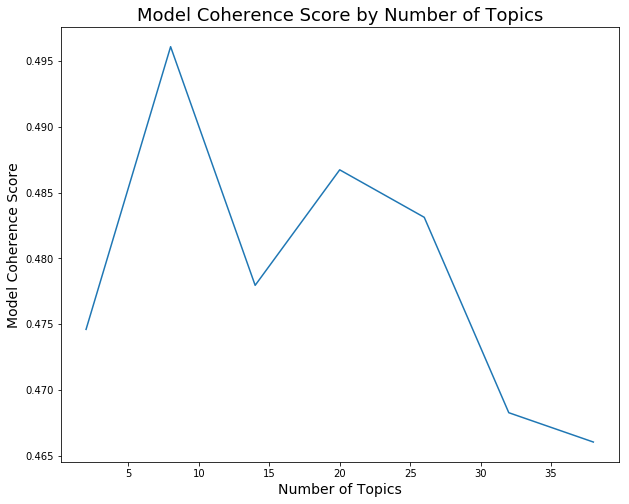

In [48]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10,8))
plt.plot(x, MALLET_coherence_values)
plt.title('Model Coherence Score by Number of Topics', fontsize = 18)
plt.xlabel("Number of Topics", fontsize = 14)
plt.ylabel("Model Coherence Score", fontsize = 14)
plt.show()

In [49]:
# Print the coherence scores
for m, cv in zip(x, MALLET_coherence_values):
    print("Number of Topics =", m, ", Coherence Value: ", round(cv, 4))

Number of Topics = 2 , Coherence Value:  0.4746
Number of Topics = 8 , Coherence Value:  0.4961
Number of Topics = 14 , Coherence Value:  0.4779
Number of Topics = 20 , Coherence Value:  0.4867
Number of Topics = 26 , Coherence Value:  0.4831
Number of Topics = 32 , Coherence Value:  0.4683
Number of Topics = 38 , Coherence Value:  0.466


As we can see, using the LDA Mallet topic modeling toolkit has much better results. Whereas gensim's built-in LDA algorithm resulted in mostly coherence values dangling in the mid-high 0.30s, using MALLET resulted in a peak coherence value of nearly 0.5. 

Let's select 20 as the number of topics since that has the highest coherence value in the list at 0.498.

In [67]:
# Select the model and print the topics
MALLET_optimal_model = MALLET_model_list[3]
MALLET_model_topics = MALLET_optimal_model.show_topics(formatted=False)
pprint(MALLET_optimal_model.print_topics(num_words=10))

[(0,
  '0.082*"year" + 0.066*"job" + 0.060*"school" + 0.053*"college" + '
  '0.052*"parent" + 0.031*"time" + 0.029*"work" + 0.028*"student" + '
  '0.024*"graduate" + 0.024*"start"'),
 (1,
  '0.140*"year" + 0.052*"high" + 0.045*"option" + 0.036*"low" + 0.034*"good" + '
  '0.029*"worth" + 0.022*"large" + 0.020*"share" + 0.020*"increase" + '
  '0.018*"point"'),
 (2,
  '0.102*"month" + 0.081*"move" + 0.061*"rent" + 0.052*"live" + '
  '0.042*"expense" + 0.032*"saving" + 0.024*"apartment" + 0.019*"monthly" + '
  '0.019*"food" + 0.016*"gas"'),
 (3,
  '0.197*"money" + 0.090*"put" + 0.089*"save" + 0.068*"good" + 0.062*"start" + '
  '0.044*"’" + 0.043*"make" + 0.030*"idea" + 0.026*"advice" + 0.019*"dollar"'),
 (4,
  '0.098*"job" + 0.095*"company" + 0.057*"offer" + 0.040*"salary" + '
  '0.036*"work" + 0.024*"position" + 0.024*"current" + 0.021*"raise" + '
  '0.019*"experience" + 0.016*"bonus"'),
 (5,
  '0.106*"house" + 0.086*"home" + 0.061*"buy" + 0.053*"mortgage" + '
  '0.037*"sell" + 0.029*"liv

We can better identify topics in the model such as topic 0 (loan), topic 4 (taxes), topic 5 (car), topic 6 (monthly expenses), topic 7 (bank account), topic 15 (employment). 

Now that we have created the topics, let's actually assign the topics to each post. The way the LDA model works in gensim is that each document is assigned a portion of multiple topics rather than a single one. Therefore, the most simple way of picking a topic for a given post is to select whichever topic has the greatest topic percentage contribution.

In [59]:
def topic_assignment(model, corpus, text):
    # Create empty dataframe
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for n, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Main topic, Percent Contribution and Keywords for each document
        for j, (topic_num, perc_topic) in enumerate(row):
            # We only want the main topic
            if j == 0:   
                wp = model.show_topic(topic_num) # returns the topic words and proportion of each word
                topic_keywords = ", ".join([word for word, prop in wp])
                # Append the Topic number, Proportion of Contribution and the Topic Keywords for each row
                topics_df = topics_df.append(pd.Series([int(topic_num), round(perc_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Main_Topic', 'Topic_Proportion', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(text)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topics = topic_assignment(model=MALLET_optimal_model, corpus=corpus, text=df.text)

# Format
df_main_topic = df_topics.reset_index()
df_main_topic.columns = ['Doc_Number', 'Main_Topic', 'Topic_Proportion', 'Keywords', 'Text']

In [60]:
# Show
df_main_topic[:10]

,Doc_Number,Main_Topic,Topic_Proportion,Keywords,Text
0,0,13.0,0.0730,"pay, debt, month, owe, make, year, extra, end,...",Ways to make extra side money?
1,1,8.0,0.0699,"bill, back, pay, due, lose, ago, mom, dad, tim...","(Year UPDATE) Legally blind, going homeless, h..."
2,2,7.0,0.1245,"work, time, week, day, hour, give, business, f...","19, being kicked out So i just found out last ..."
3,3,15.0,0.1172,"account, bank, saving, check, open, money, fee...",Online Savings Account? Hello! Looking for rec...
4,4,16.0,0.0813,"make, feel, thing, spend, lot, pretty, bad, ti...",Tools for Managing Incomes and Expenses
5,5,19.0,0.0842,"good, advice, finance, people, post, personal,...","With resources like reddit, is financial consu..."
6,6,12.0,0.1695,"credit, card, score, balance, limit, apply, bu...","Credit hit from late payment, fee was waiver, ..."
7,7,14.0,0.1575,"loan, payment, interest, student, rate, pay, m...",Need Help budgetting/getting out of debt Long ...
8,8,7.0,0.1211,"work, time, week, day, hour, give, business, f...","22yo M I'm a 22 year old male, with an almost ..."
9,9,10.0,0.0984,"call, "", charge, send, number, receive, report...","Debt collector gave 2 hours to pay, yelled, sa..."


Now that we have assigned a topic to each text, let's further analyze the different topics

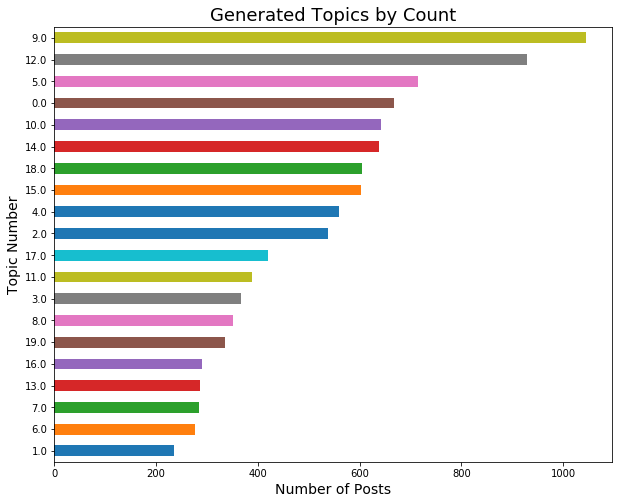

In [61]:
df_main_topic['Main_Topic'].value_counts(ascending=True).plot(kind='barh', figsize = (10,8))
plt.title('Generated Topics by Count', fontsize = 18)
plt.xlabel('Number of Posts', fontsize = 14)
plt.ylabel('Topic Number', fontsize=14)
plt.show()

Topic 0 (Loans), Topic 14 (Credit) and Topic 13 (Investing) are the 3 most common topics in terms of number of posts. On the flip side, Topics 1, 10, and 9 are the 3 least common topics and are very vague in what they represent. In other words, it seems to be the case that the more common topics also have a more specific topic representation/idea. 

In [62]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topics.groupby('Main_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Proportion'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3613,"year, job, school, college, parent, time, work...",30(m) Grad school decision with job. I'm curre...
1,1.0,0.2743,"year, high, option, low, good, worth, large, s...",How Should I Handle Employer-Granted Stock Opt...
2,2.0,0.3084,"month, move, rent, live, expense, saving, apar...",Moving out for the first time - Need advice So...
3,3.0,0.2219,"money, put, save, good, start, ’, make, idea, ...","Cash or loan for Tesla? Hey all, I’m trying to..."
4,4.0,0.3838,"job, company, offer, salary, work, position, c...",Refining strategy for upcoming promotion. Tips...
5,5.0,0.3626,"house, home, buy, mortgage, sell, live, proper...","Buying Property from Grandparents Hi all,\n\nI..."
6,6.0,0.3640,"question, state, give, receive, file, order, a...",IRS will be modifying Form 1040 series transcr...
7,7.0,0.3750,"work, time, week, day, hour, give, business, f...",Hourly workers: if you're not doing anything f...
8,8.0,0.3792,"bill, back, pay, due, lose, ago, mom, dad, tim...",Hospital told us their specialist had gone hom...
9,9.0,0.6001,"fund, invest, retirement, stock, investment, i...","401k Portfolio Background: 82k annually, 25 ye..."


In [63]:
# Number of Documents for Each Topic
topic_counts = df_topics['Main_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
x = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_main_topics = pd.concat([x, topic_counts, topic_contribution], axis = 1)

# Change Column names
df_main_topics.columns = ['Main_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_main_topics

,Main_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"year, job, school, college, parent, time, work...",667,0.0655
1,1.0,"year, high, option, low, good, worth, large, s...",235,0.0231
2,2.0,"month, move, rent, live, expense, saving, apar...",538,0.0529
3,3.0,"money, put, save, good, start, ’, make, idea, ...",367,0.0361
4,4.0,"job, company, offer, salary, work, position, c...",559,0.0549
5,5.0,"house, home, buy, mortgage, sell, live, proper...",714,0.0702
6,6.0,"question, state, give, receive, file, order, a...",276,0.0271
7,7.0,"work, time, week, day, hour, give, business, f...",285,0.0280
8,8.0,"bill, back, pay, due, lose, ago, mom, dad, tim...",352,0.0346
9,9.0,"fund, invest, retirement, stock, investment, i...",1045,0.1027


In [113]:
optimal_model.get_document_topics(corpus[10])

[(2, 0.48453128), (14, 0.2365637), (19, 0.184052)]

In [110]:
print('Sample Document: ',''.join(df.text[10]))
for index, score in sorted(optimal_model[corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, optimal_model.print_topic(index, 10)))

Sample Document:  Please help me review my budget . . underpaid tech worker in SF. Thanks 

Score: 0.48454421758651733	 
Topic: 0.024*"not" + 0.016*"would" + 0.016*"transfer" + 0.014*"account" + 0.013*"do" + 0.013*"get" + 0.012*"bank" + 0.012*"be" + 0.009*"money" + 0.009*"have"

Score: 0.23654302954673767	 
Topic: 0.030*"job" + 0.024*"company" + 0.022*"work" + 0.018*"offer" + 0.017*"new" + 0.015*"get" + 0.013*"salary" + 0.012*"time" + 0.011*"year" + 0.010*"do"

Score: 0.184059739112854	 
Topic: 0.052*"car" + 0.024*"insurance" + 0.019*"get" + 0.013*"not" + 0.013*"new" + 0.013*"year" + 0.013*"buy" + 0.012*"would" + 0.010*"pay" + 0.010*"month"


### 2b) Topic Modeling with Sci-kit Learn

There are quite a few noticeable changes when using Sci-Kit Learn's LDA model. The first is that it vectorizes the words using sci-kit learn's CounterVectorizer function. This also allows you to conveniently fit and transform the data. 

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)